# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_prediction
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData, augmentReducedData
from src.data_utils import mice
from src.time_series_utils import check_stationarity

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

Using GPU to train
2.19.0
[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data
conf

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx',
   'target_start_date': '2022-01-01',
   'target_end_date': '2022-12-31'},
  'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2021-12-31'},
  'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2022-12-31',
   'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv',
   'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv',
   'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv',
   'merged_data_dir_all_locatio

# PM DATA

## Load 2022 dataset

In [4]:
df_pm2022_raw = []
for csv_file in sorted(glob.glob(f'{conf["dataset"]["pm2022"]["file_dir"]}/*')):
    df_current_station = pd.read_csv(csv_file)
    station = csv_file.split("/")[-1].split(".")[0]
    print(f"{csv_file} - {len(df_current_station)} records")
    df_current_station["station"] = station
    df_pm2022_raw.append(df_current_station)
df_pm2022_raw = pd.concat(df_pm2022_raw, axis=0, ignore_index=True)
df_pm2022_raw

/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2022/214.csv - 8760 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2022/215.csv - 4513 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2022/216.csv - 8761 records


,Unnamed: 0,TSP,PM2_5,O3,CO,NO2,SO2,date,station,Temperature,Humid
0,0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,214,NaN,NaN
1,1,51.768333,21.285000,44.916667,0.672500,0.036300,0.042500,2022-01-01 01:00:00,214,NaN,NaN
2,2,43.588889,18.414815,46.148148,0.577037,0.034759,0.035926,2022-01-01 02:00:00,214,NaN,NaN
3,3,43.988095,19.242857,46.357143,0.542143,0.035643,0.030238,2022-01-01 03:00:00,214,NaN,NaN
4,4,40.928333,18.140000,46.700000,0.507000,0.036550,0.029667,2022-01-01 04:00:00,214,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
22029,8756,126.168333,50.530000,66.116667,2.006500,0.083217,0.104167,2022-12-31 20:00:00,216,27.401667,68.026667
22030,8757,139.688333,55.055000,55.133333,2.418833,0.084300,0.130167,2022-12-31 21:00:00,216,27.603333,66.965000
22031,8758,63.565000,26.078333,46.750000,1.481500,0.066650,0.075833,2022-12-31 22:00:00,216,27.036667,63.361667
22032,8759,51.705000,21.161667,50.016667,1.301167,0.067783,0.060833,2022-12-31 23:00:00,216,26.358333,63.343333


In [5]:
# Convert "time" columns to Pandas datetime
df_pm2022_raw["date"] = pd.to_datetime(df_pm2022_raw["date"])

# Lower case all column names
df_pm2022_raw = df_pm2022_raw.rename(columns={name: name.lower() for name in df_pm2022_raw.columns})

# Work with columns
df_pm2022_raw = df_pm2022_raw.drop(columns=["unnamed: 0"])
df_pm2022_raw = df_pm2022_raw.rename(columns={"pm2_5": "pm25"})

# Print
df_pm2022_raw

,tsp,pm25,o3,co,no2,so2,date,station,temperature,humid
0,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00,214,NaN,NaN
1,51.768333,21.285000,44.916667,0.672500,0.036300,0.042500,2022-01-01 01:00:00,214,NaN,NaN
2,43.588889,18.414815,46.148148,0.577037,0.034759,0.035926,2022-01-01 02:00:00,214,NaN,NaN
3,43.988095,19.242857,46.357143,0.542143,0.035643,0.030238,2022-01-01 03:00:00,214,NaN,NaN
4,40.928333,18.140000,46.700000,0.507000,0.036550,0.029667,2022-01-01 04:00:00,214,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
22029,126.168333,50.530000,66.116667,2.006500,0.083217,0.104167,2022-12-31 20:00:00,216,27.401667,68.026667
22030,139.688333,55.055000,55.133333,2.418833,0.084300,0.130167,2022-12-31 21:00:00,216,27.603333,66.965000
22031,63.565000,26.078333,46.750000,1.481500,0.066650,0.075833,2022-12-31 22:00:00,216,27.036667,63.361667
22032,51.705000,21.161667,50.016667,1.301167,0.067783,0.060833,2022-12-31 23:00:00,216,26.358333,63.343333


In [6]:
sorted(df_pm2022_raw["station"].unique())

['214', '215', '216']

## Load 2021 dataset

In [7]:
df_pm2021_raw = []
for csv_file in sorted(glob.glob(f'{conf["dataset"]["pm2021"]["file_dir"]}/*')):
    df_current_station = pd.read_csv(csv_file)
    station = csv_file.split("/")[-1].split(".")[0]
    print(f"{csv_file} - {len(df_current_station)} records")
    df_current_station["station"] = station
    df_pm2021_raw.append(df_current_station.dropna(axis=1, how="all"))
df_pm2021_raw = pd.concat(df_pm2021_raw, axis=0, ignore_index=True)
df_pm2021_raw

/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2021/211.csv - 8166 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2021/212.csv - 8084 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2021/213.csv - 8084 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2021/214.csv - 8084 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2021/215.csv - 8084 records
/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/quan-trac/2021/216.csv - 8065 records


,Unnamed: 0,date,Station number,TSPug/m3,PM2.5ug/m3,O3ug/m3,CO (ug/m3),NO2 (ug/m3,Temperature,Humid,...,Temperature.1,Humid.1,dewPoint.1,humidity.1,pressure.1,uvIndex.1,ozone.1,ws.1,wd.1,station
0,0,2021-02-20 11:00:00,1,15.400000,9.200000,25.519000,1512.720000,28.230000,26.100000,60.500000,...,37.778333,99.135,78.81,0.97,1016.0,13.0,280.4,10.0,360.0,211
1,1,2021-02-20 12:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
2,2,2021-02-20 13:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
3,3,2021-02-20 14:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
4,4,2021-02-20 15:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48562,8060,2022-01-26 12:00:00,6,127.290000,54.080000,144.771250,1344.831000,85.568267,32.703333,60.336667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216
48563,8061,2022-01-26 13:00:00,6,120.145000,49.773333,134.629083,2105.011000,82.651167,34.370000,55.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216
48564,8062,2022-01-26 14:00:00,6,112.141667,45.770000,146.832400,2391.511000,107.211267,33.045000,56.741667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216
48565,8063,2022-01-26 15:00:00,6,135.530000,56.446667,240.958250,2418.442000,184.059600,30.943333,66.025000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216


In [8]:
# Convert "time" columns to Pandas datetime
df_pm2021_raw['date'] = pd.to_datetime(df_pm2021_raw['date'])

# Rename columns
df_pm2021_raw = df_pm2021_raw.rename(columns={
    "TSPug/m3": "tsp",
    "PM2.5ug/m3": "pm25",
    "O3ug/m3": "o3",
    "NO2 (ug/m3": "no2",
    "CO (ug/m3)": "co",
})

# Lower case all column names
df_pm2021_raw.rename(columns={name: name.lower() for name in df_pm2021_raw.columns}, inplace=True)

# Remove unnecessary columns
df_pm2021_raw.drop(columns=set(df_pm2021_raw.columns) - set(df_pm2022_raw.columns), inplace=True)

# Print
df_pm2021_raw

,date,tsp,pm25,o3,co,no2,temperature,humid,station
0,2021-02-20 11:00:00,15.400000,9.200000,25.519000,1512.720000,28.230000,26.100000,60.500000,211
1,2021-02-20 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
2,2021-02-20 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
3,2021-02-20 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
4,2021-02-20 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
...,...,...,...,...,...,...,...,...,...
48562,2022-01-26 12:00:00,127.290000,54.080000,144.771250,1344.831000,85.568267,32.703333,60.336667,216
48563,2022-01-26 13:00:00,120.145000,49.773333,134.629083,2105.011000,82.651167,34.370000,55.100000,216
48564,2022-01-26 14:00:00,112.141667,45.770000,146.832400,2391.511000,107.211267,33.045000,56.741667,216
48565,2022-01-26 15:00:00,135.530000,56.446667,240.958250,2418.442000,184.059600,30.943333,66.025000,216


## Merge dataset

In [9]:
# Drop so2 column in 2022 dataset
df_pm2022_raw.drop(columns=["so2"], inplace=True)

# Start merging
df_pm_raw = pd.concat([df_pm2021_raw, df_pm2022_raw], axis=0)

# Rename column "date" to "time"
df_pm_raw.rename({"date": "time"}, axis=1, inplace=True)

# Sort data by "station" then "time"
df_pm_raw.sort_values(by=["station", "time"], ascending=[True, True], inplace=True)

# Set index
df_pm_raw.set_index("time", inplace=True)

# Print
df_pm_raw

,tsp,pm25,o3,co,no2,temperature,humid,station
time,,,,,,,,
2021-02-20 11:00:00,15.400000,9.200000,25.519000,1512.720000,28.230000,26.100000,60.500000,211
2021-02-20 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
2021-02-20 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
2021-02-20 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
2021-02-20 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,211
...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,126.168333,50.530000,66.116667,2.006500,0.083217,27.401667,68.026667,216
2022-12-31 21:00:00,139.688333,55.055000,55.133333,2.418833,0.084300,27.603333,66.965000,216
2022-12-31 22:00:00,63.565000,26.078333,46.750000,1.481500,0.066650,27.036667,63.361667,216


In [10]:
df_pm_raw.to_csv('df_pm_raw.csv', index=True)

## EDA

### Statistic

In [11]:
stat = df_pm_raw.describe()
display(stat)

,tsp,pm25,o3,co,no2,temperature,humid
count,51760.000000,51779.000000,43981.000000,45612.000000,49421.000000,40821.000000,40821.000000
mean,46.561162,21.688056,79.942610,636.226876,56.321992,28.080494,66.952490
std,37.129038,13.846283,38.299232,698.922562,64.561837,3.877223,23.308133
min,0.000000,0.000000,0.000000,0.000000,0.000000,20.055000,12.435000
25%,26.356250,12.770000,50.416667,1.105333,0.081417,26.331670,60.138333
50%,39.870000,17.981667,74.430420,641.187000,48.649700,28.200000,72.970000
75%,60.153333,26.372837,100.898200,901.360564,83.780367,30.556670,83.278333
max,1344.311667,218.061667,377.288600,21092.570770,461.090000,39.256667,99.283333


### Check null

In [12]:
nullstat = pd.DataFrame(df_pm_raw.isnull().sum())
nullstat.rename({0: "missing"}, axis=1, inplace=True)
nullstat

,missing
tsp,18841
pm25,18822
o3,26620
co,24989
no2,21180
temperature,29780
humid,29780
station,0


In [13]:
pm_missing_columns = list(nullstat[nullstat["missing"] > 0].index)
pm_missing_columns

['tsp', 'pm25', 'o3', 'co', 'no2', 'temperature', 'humid']

### Check each station

In [14]:
for station in df_pm_raw["station"].unique():
    print(f"Station = {station}")
    df_current_station = df_pm_raw[df_pm_raw["station"] == station]
    print(f"Number of record = {len(df_current_station)}")
    print(f"Start date = {df_current_station.index[0]}, end date = {df_current_station.index[-1]}")
    display(df_current_station.isnull().sum())
    print("=" * 100)

Station = 211
Number of record = 8166
Start date = 2021-02-20 11:00:00, end date = 2022-01-26 16:00:00


,0
tsp,3571
pm25,3513
o3,5931
co,3571
no2,5931
temperature,3505
humid,3505
station,0


Station = 212
Number of record = 8084
Start date = 2021-02-23 21:00:00, end date = 2022-01-26 16:00:00


,0
tsp,1557
pm25,1559
o3,1557
co,7726
no2,1557
temperature,1557
humid,1557
station,0


Station = 213
Number of record = 8084
Start date = 2021-02-23 21:00:00, end date = 2022-01-26 16:00:00


,0
tsp,2095
pm25,2119
o3,2096
co,2096
no2,2095
temperature,2095
humid,2095
station,0


Station = 214
Number of record = 16844
Start date = 2021-02-23 21:00:00, end date = 2022-12-31 23:00:00


,0
tsp,4422
pm25,4431
o3,4477
co,4422
no2,4422
temperature,10066
humid,10066
station,0


Station = 215
Number of record = 12597
Start date = 2021-02-23 21:00:00, end date = 2022-07-08 00:00:00


,0
tsp,4696
pm25,4698
o3,10069
co,4685
no2,4686
temperature,10068
humid,10068
station,0


Station = 216
Number of record = 16826
Start date = 2021-02-24 16:00:00, end date = 2023-01-01 00:00:00


,0
tsp,2500
pm25,2502
o3,2490
co,2489
no2,2489
temperature,2489
humid,2489
station,0


### Correlation matrix

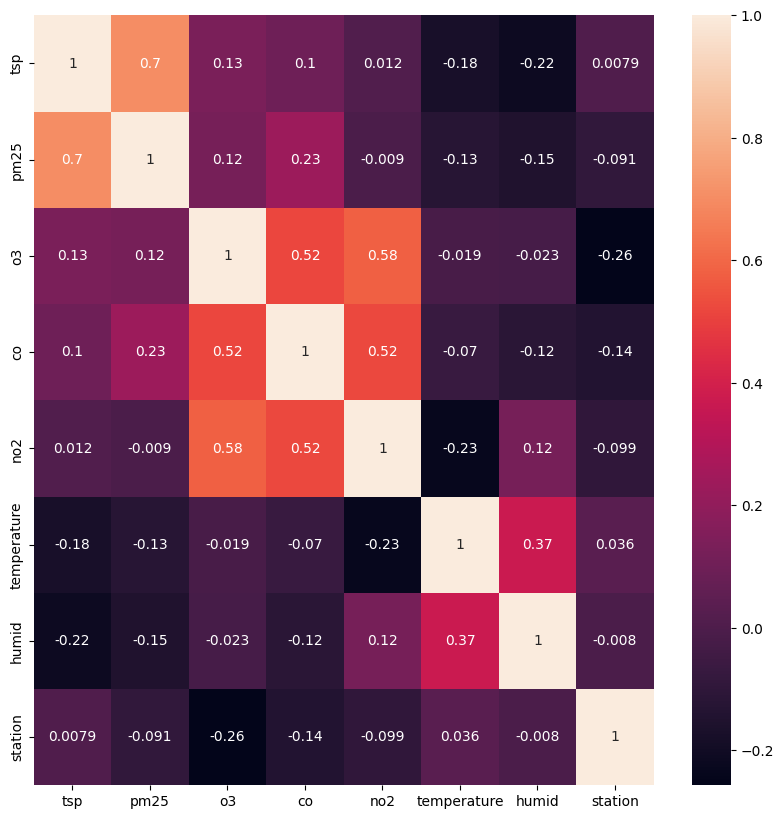

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_pm_raw.corr(), annot=True, ax=ax)
plt.show()

### Fill missing


Handling for station 211


Handling for station 212


Handling for station 213


Handling for station 214


Handling for station 215


Handling for station 216



,tsp,pm25,o3,co,no2,temperature,humid,station
time,,,,,,,,
2021-02-20 11:00:00,15.400000,9.200000,25.519000,1512.720000,28.230000,26.100000,60.500000,211.0
2021-02-20 12:00:00,61.497676,22.674156,97.304140,858.623670,131.812611,28.504555,75.959802,211.0
2021-02-20 13:00:00,61.497676,22.674156,97.304140,858.623670,131.812611,28.504555,75.959802,211.0
2021-02-20 14:00:00,61.497676,22.674156,97.304140,858.623670,131.812611,28.504555,75.959802,211.0
2021-02-20 15:00:00,61.497676,22.674156,97.304140,858.623670,131.812611,28.504555,75.959802,211.0
...,...,...,...,...,...,...,...,...
2022-12-31 20:00:00,126.168333,50.530000,66.116667,2.006500,0.083217,27.401667,68.026667,216.0
2022-12-31 21:00:00,139.688333,55.055000,55.133333,2.418833,0.084300,27.603333,66.965000,216.0
2022-12-31 22:00:00,63.565000,26.078333,46.750000,1.481500,0.066650,27.036667,63.361667,216.0


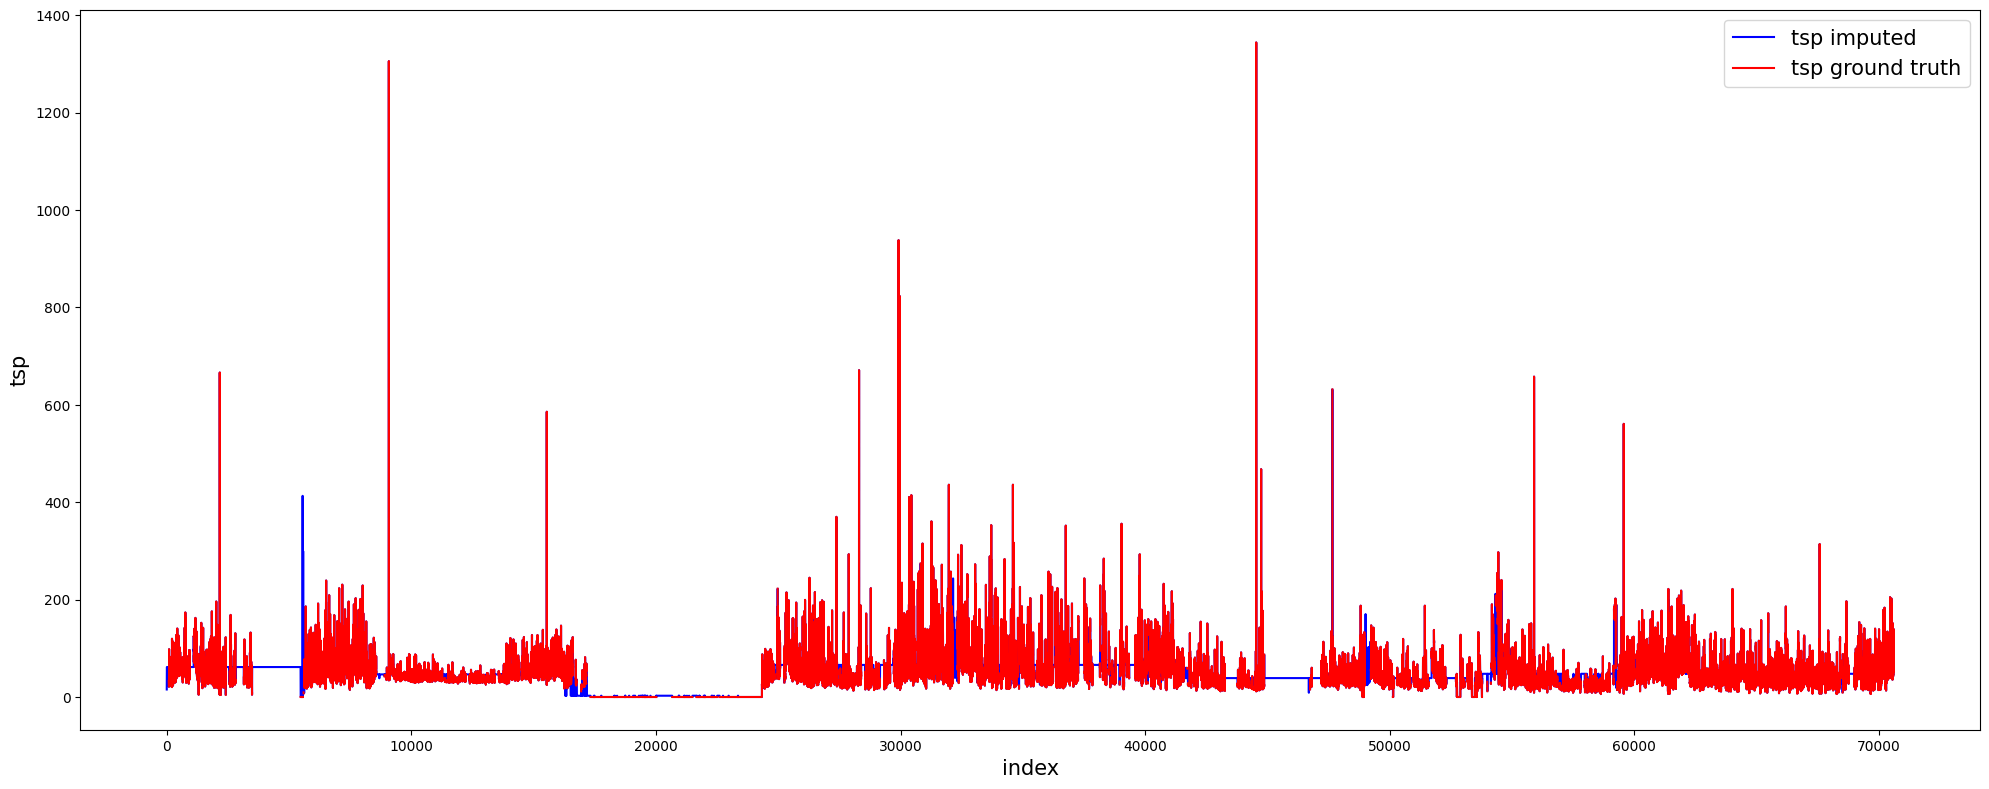

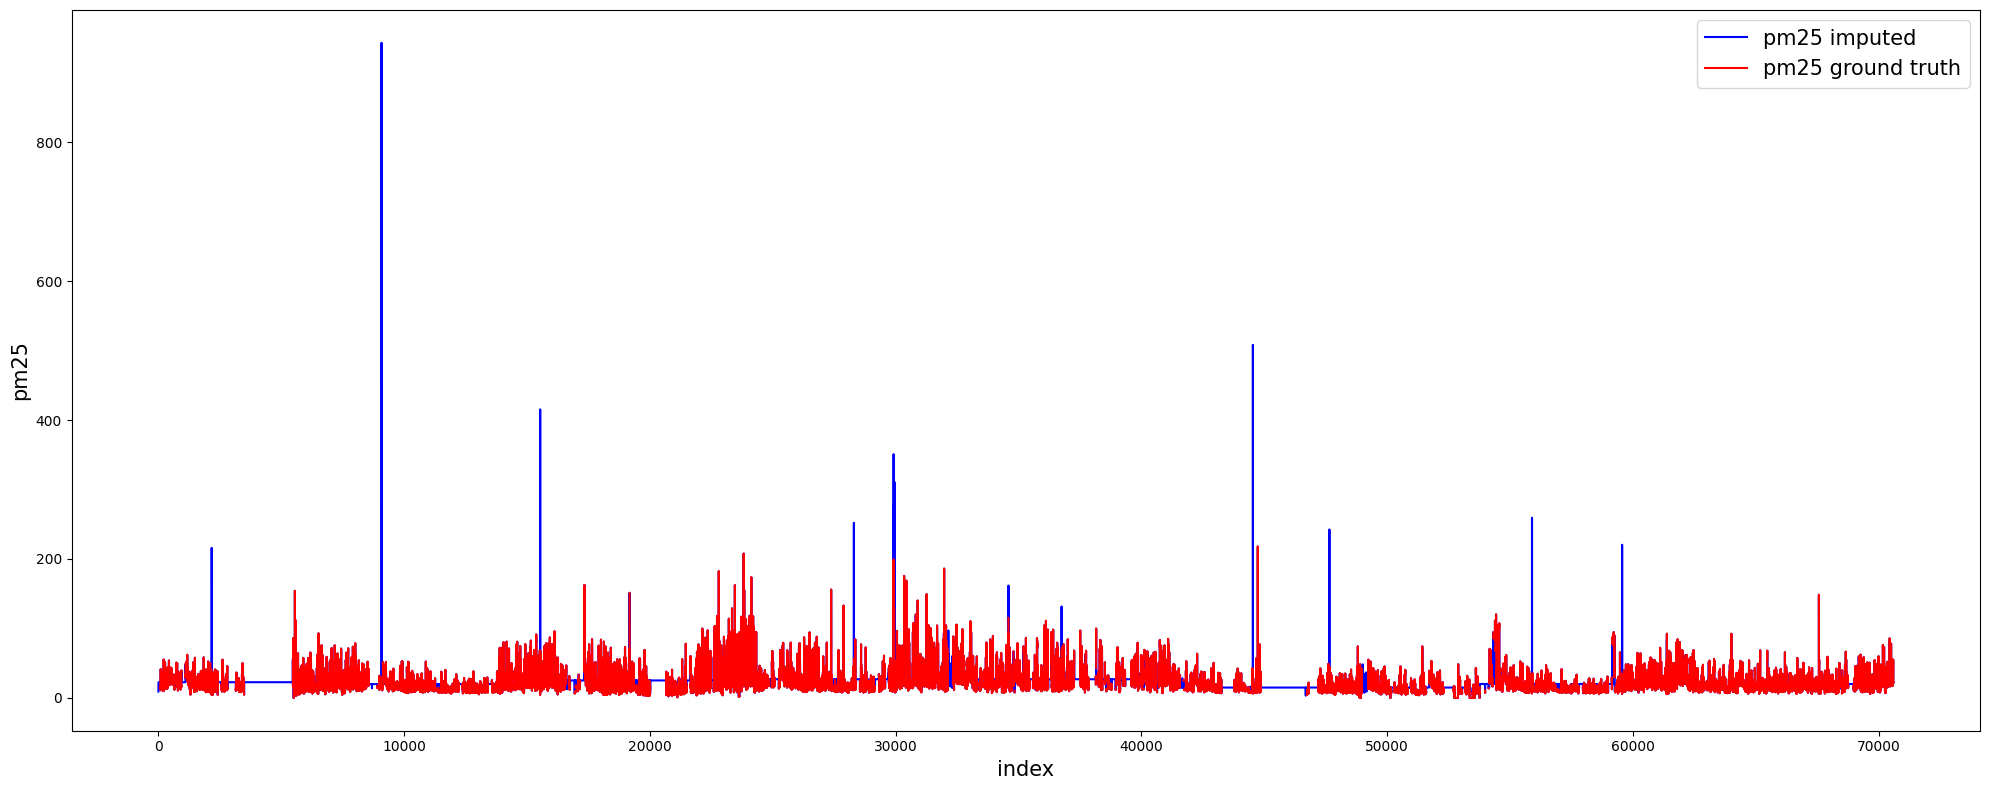

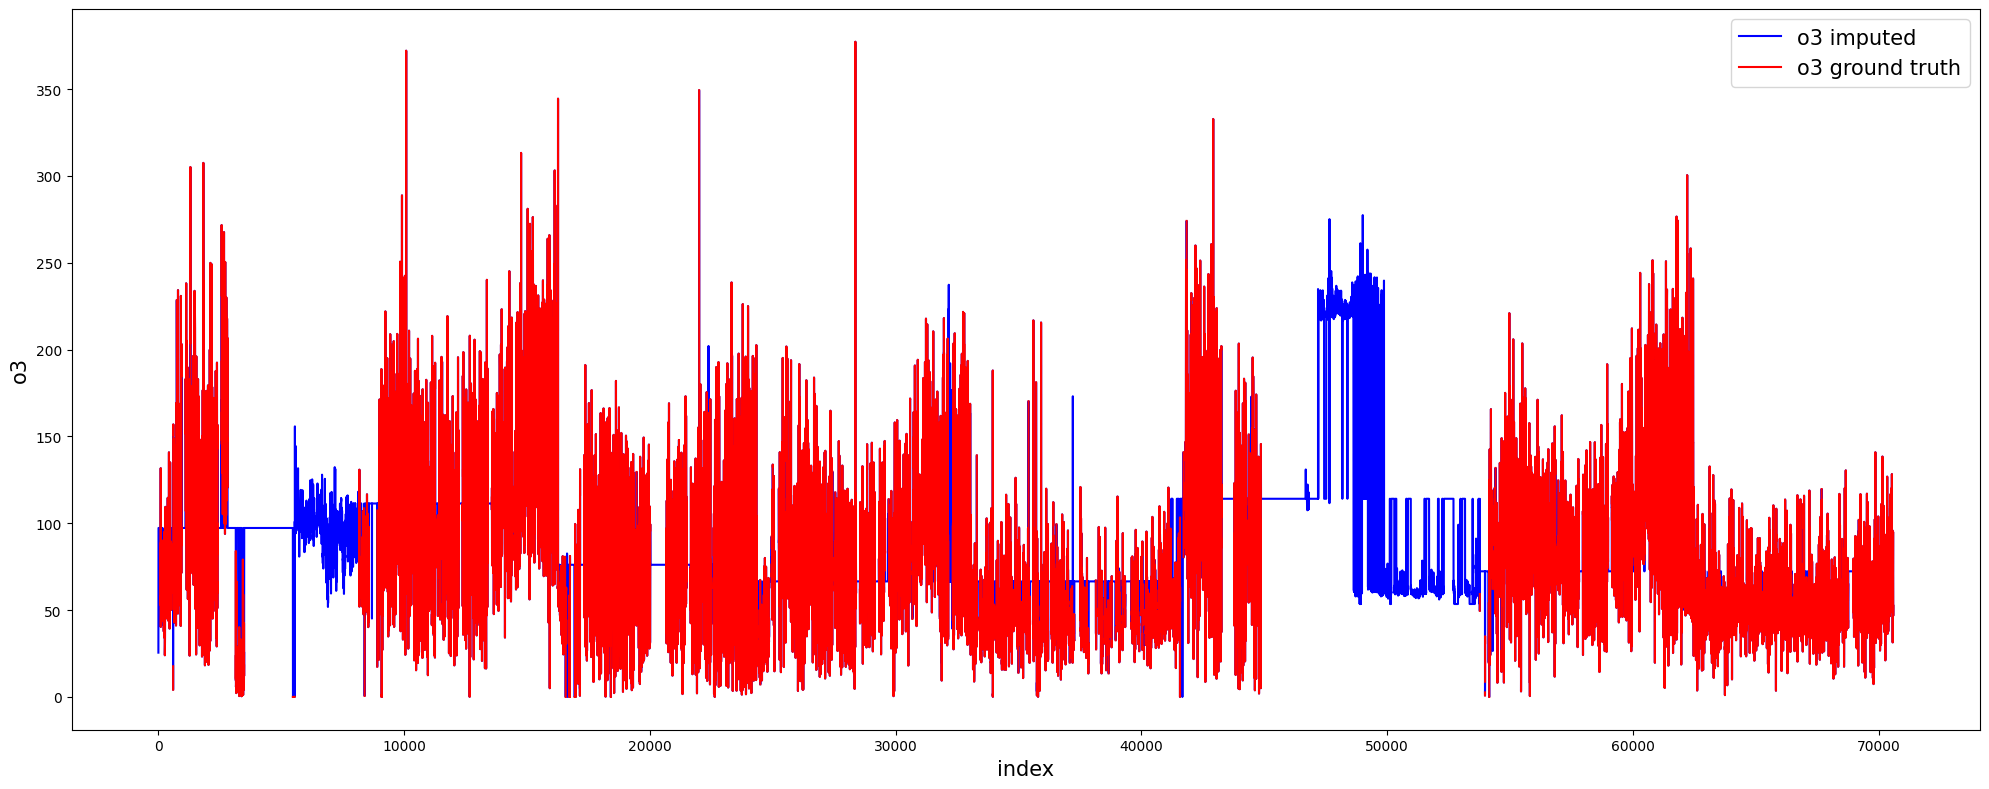

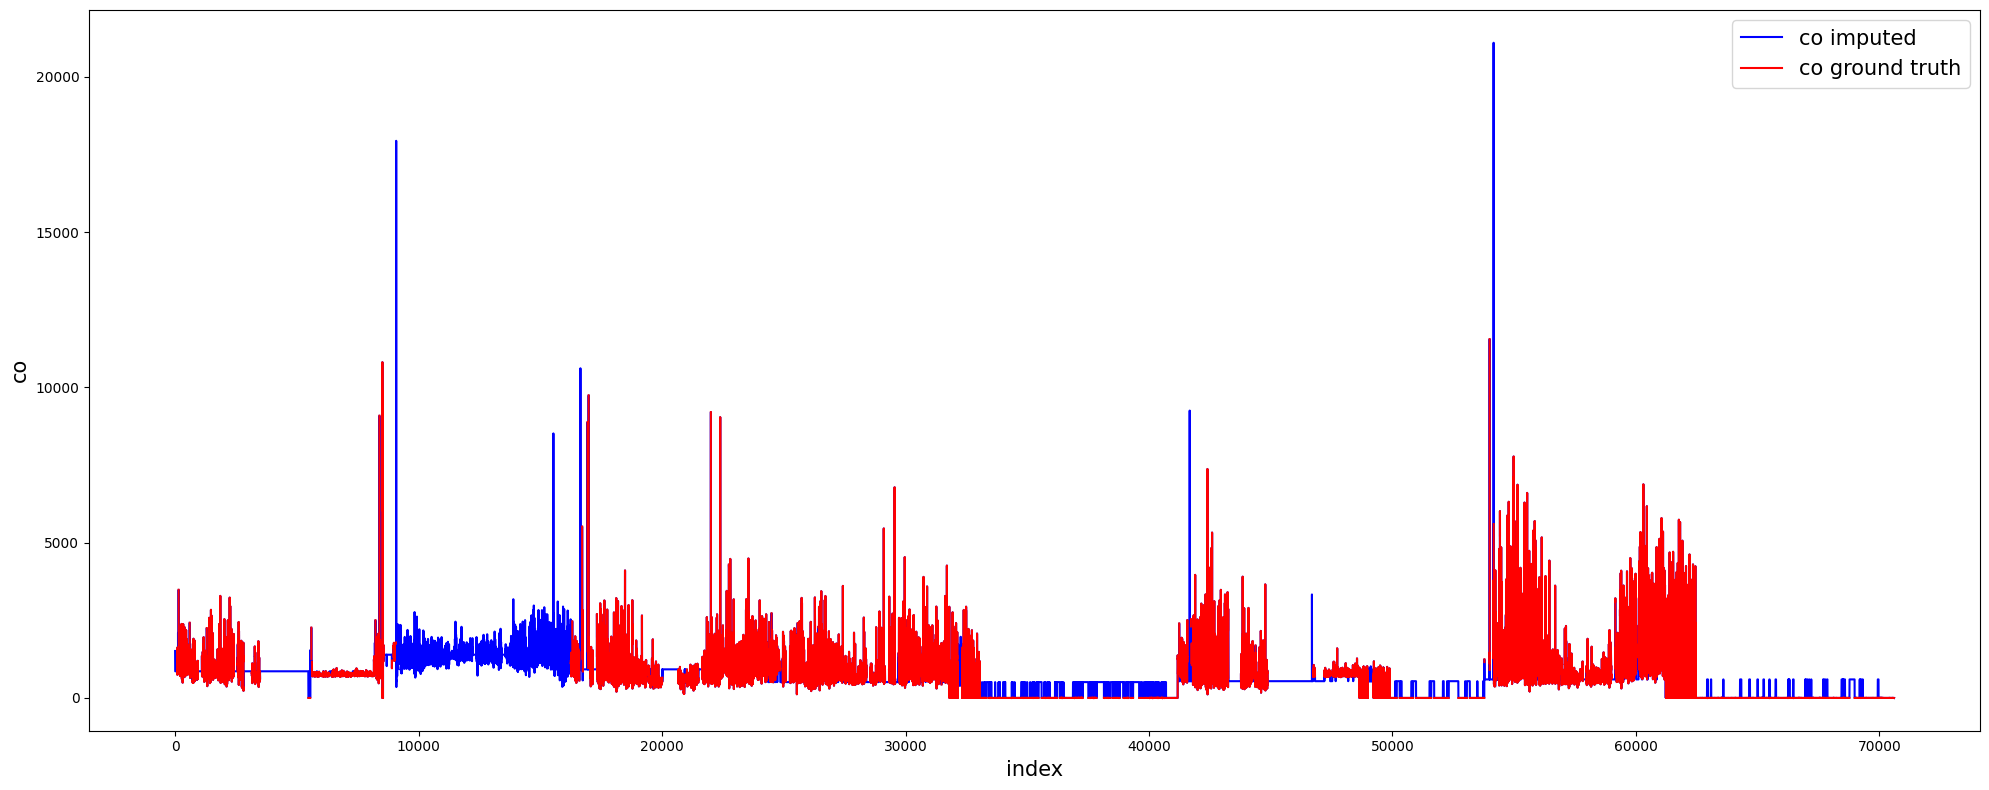

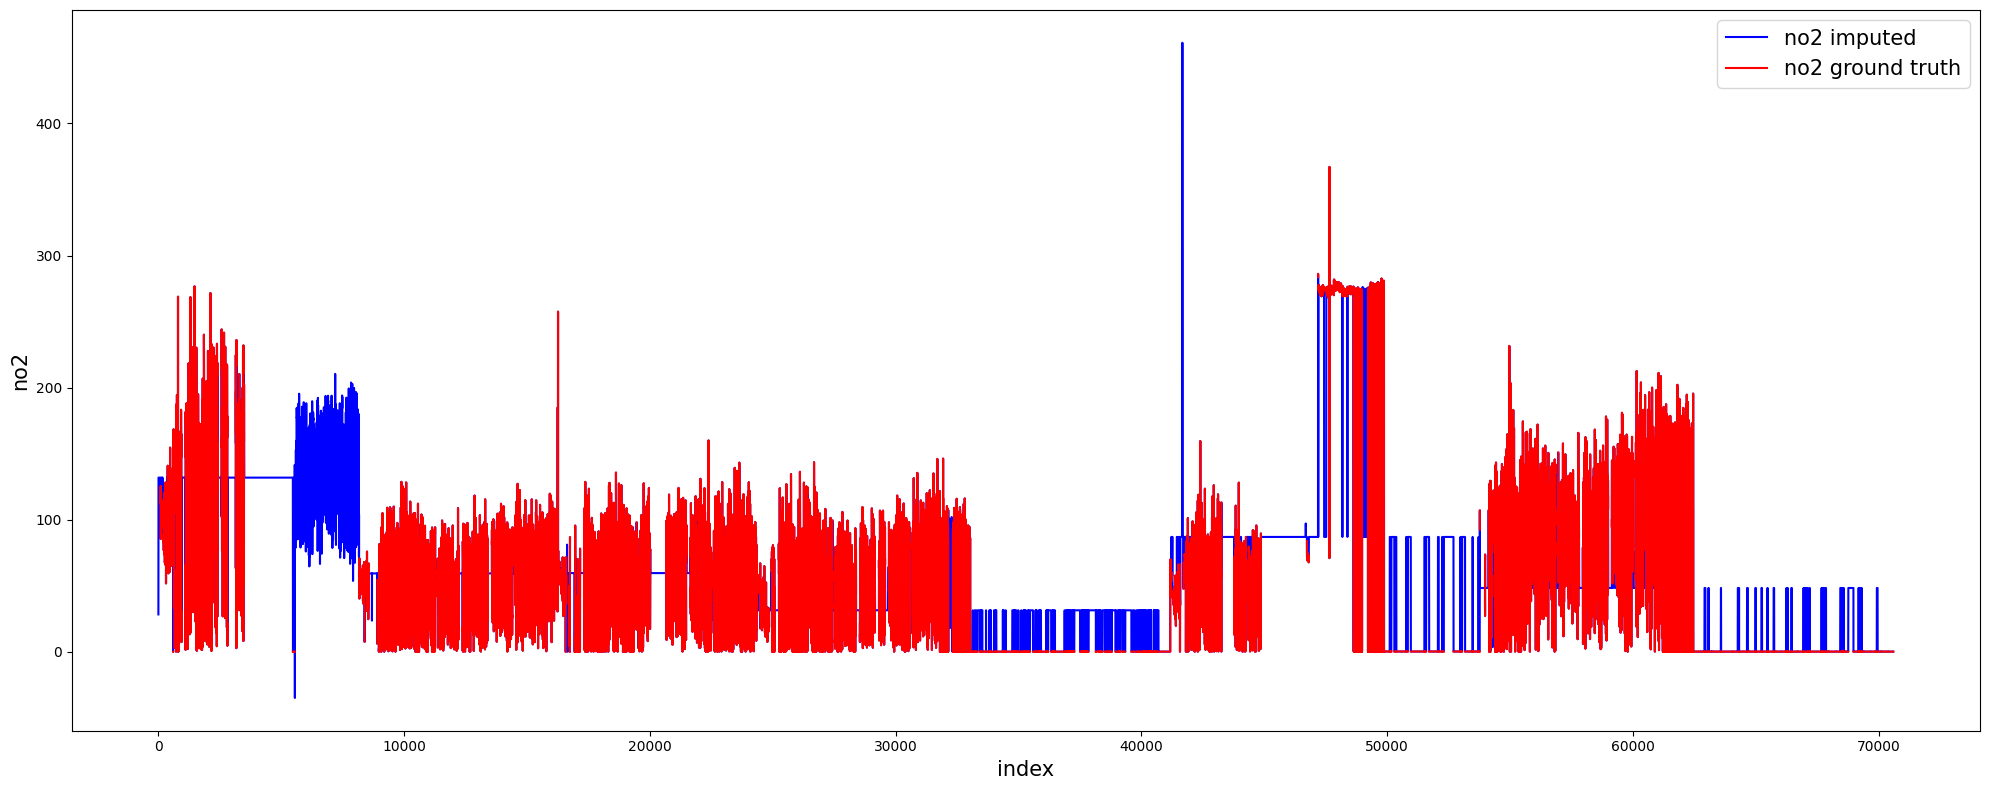

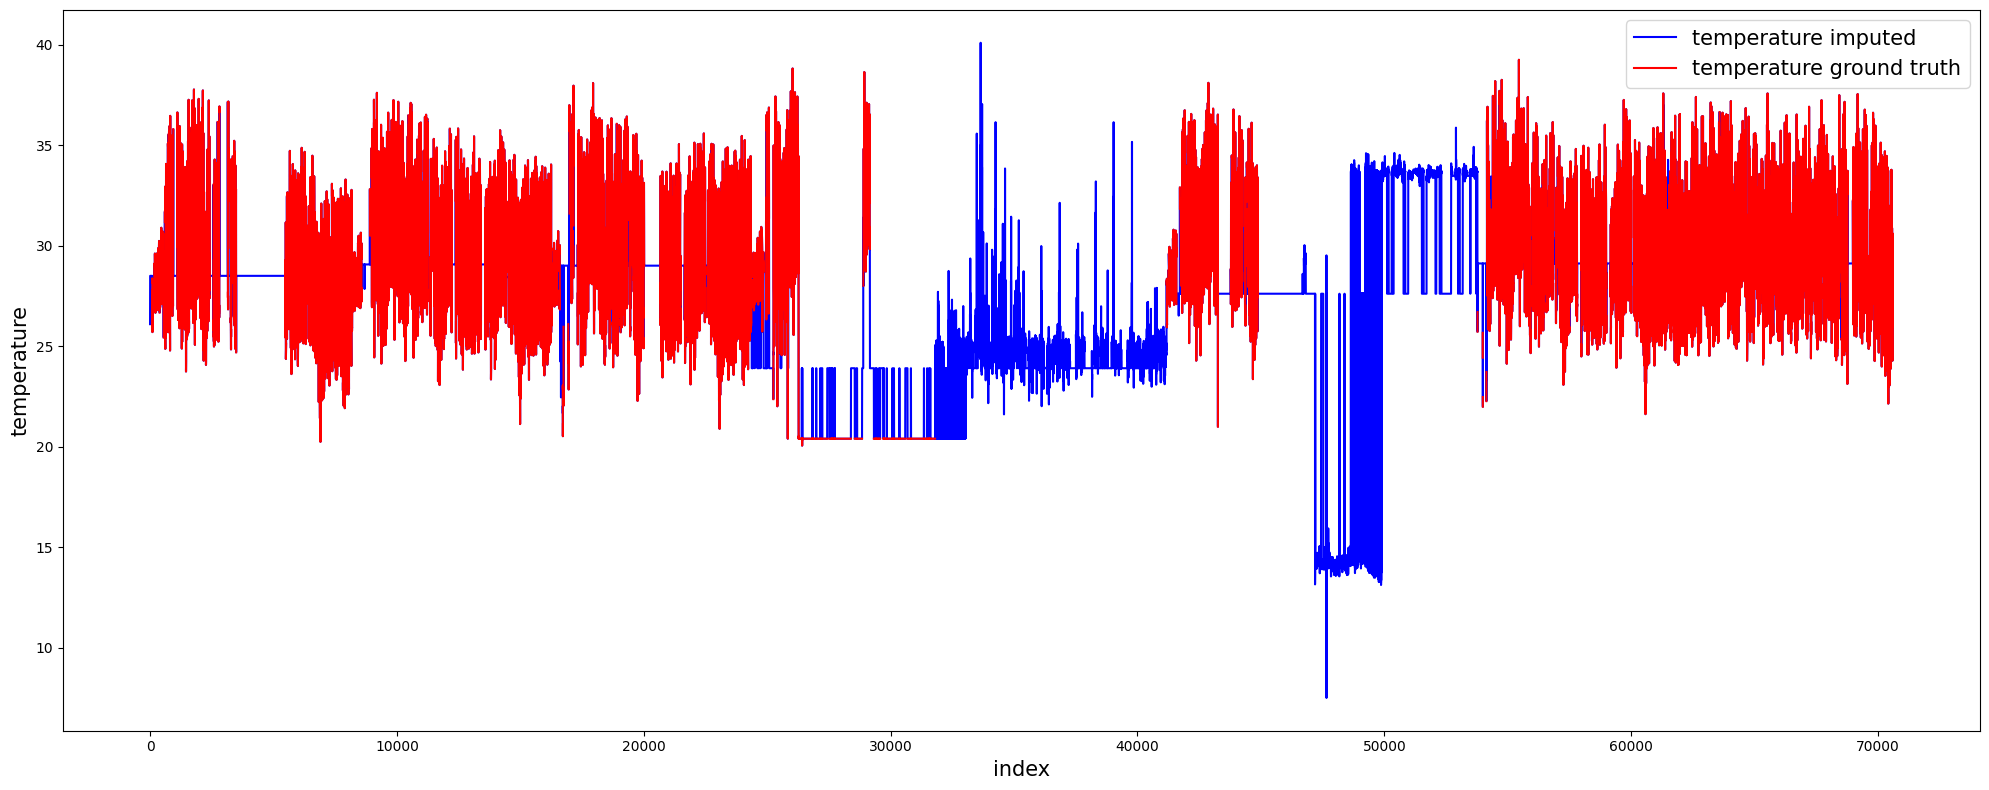

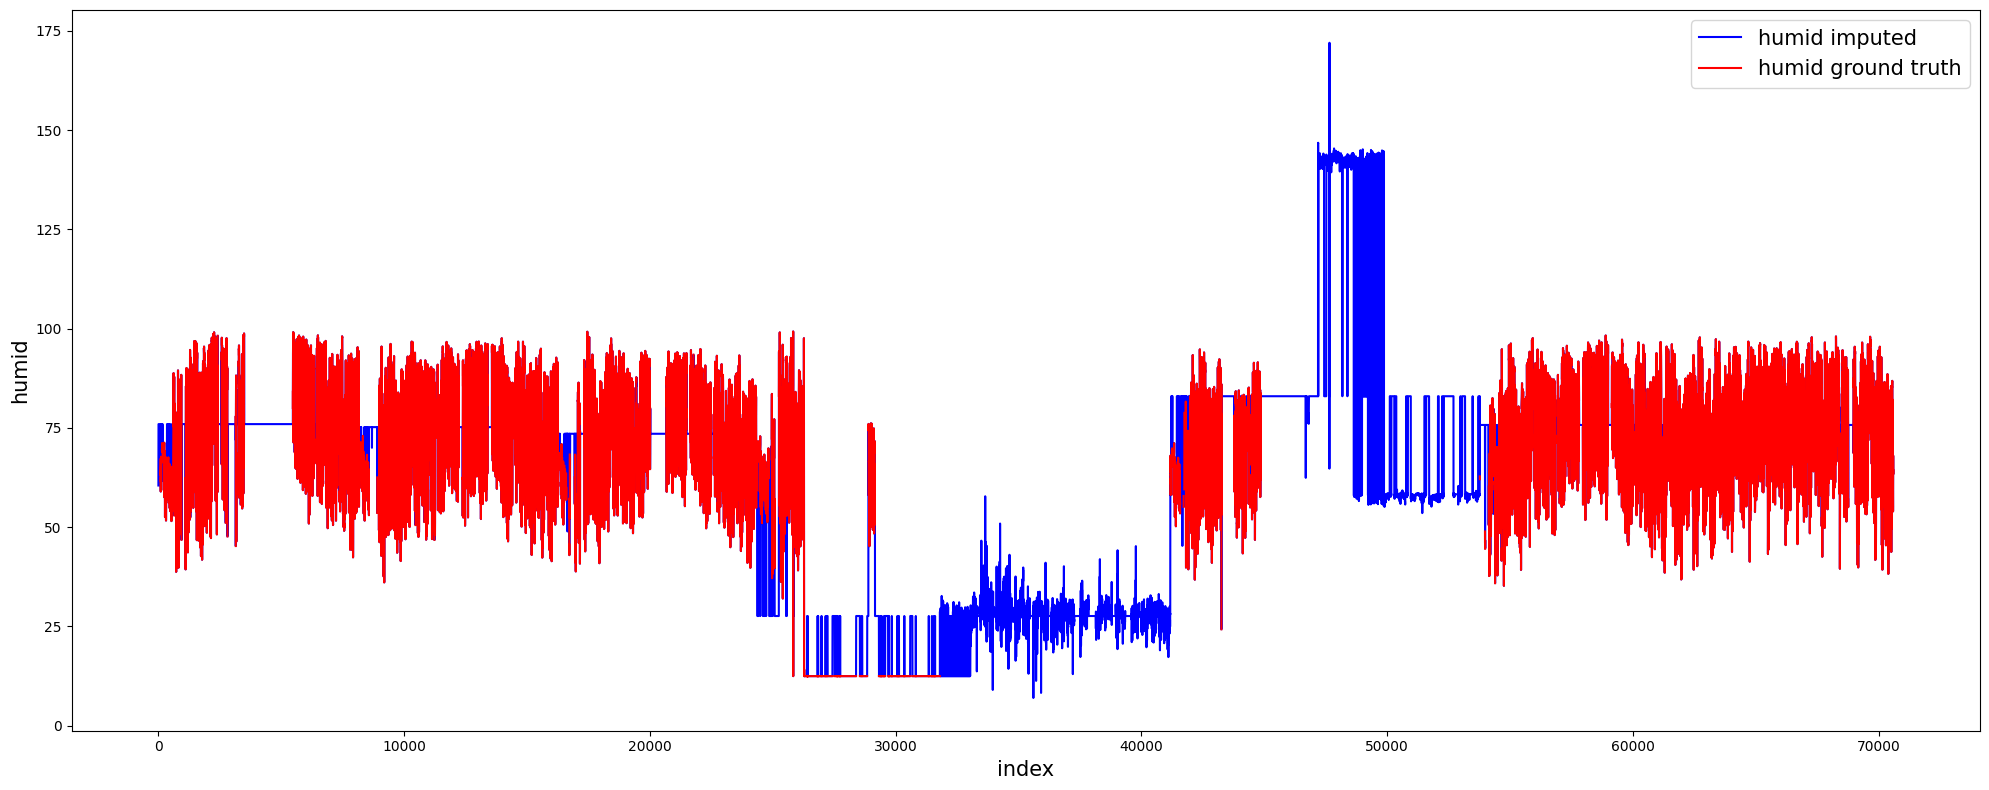

In [16]:
all_stations_df = []

for station in df_pm_raw["station"].unique():
    print(f"\nHandling for station {station}\n")
    # Get dataframe of current station
    df_aod_current_station = df_pm_raw[df_pm_raw["station"] == station]

    # Drop records which miss all features
    df_aod_current_station = df_aod_current_station.dropna(how="all")

    # Fill missing columns
    df_aod_current_station_imputed = mice(df_aod_current_station)

    # Store file for debugging after filling missing values
    #df_aod_current_station_imputed.to_csv(f"{conf['workspace']['data_by_station_dir']}/df_aod_{station}.csv", index=True)

    # Reappend the location to dataset
    all_stations_df.append(df_aod_current_station_imputed)

# Merge all stations
df_pm_imputed = pd.concat(all_stations_df)
display(df_pm_imputed)

# Draw plot for each feature
for feat in pm_missing_columns:
    plot_2_data(data1=df_pm_imputed[feat],
            datalabel1=f"{feat} imputed",
            data2=df_pm_raw[feat],
            datalabel2=f"{feat} ground truth",
            ylabel=feat,
            xlabel="index")

### Seasonal analysis

In [17]:
print("Checking for pm25")
display(check_stationarity(df_pm_imputed["pm25"]))

print("Checking for tsp")
display(check_stationarity(df_pm_imputed["tsp"]))

print("Checking for no2")
display(check_stationarity(df_pm_imputed["no2"]))

print("Checking for o3")
display(check_stationarity(df_pm_imputed["o3"]))

print("Checking for co")
display(check_stationarity(df_pm_imputed["co"]))

print("Checking for temperature")
display(check_stationarity(df_pm_imputed["temperature"]))

print("Checking for humid")
display(check_stationarity(df_pm_imputed["humid"]))

Checking for pm25
ADF Statistic: -16.949102
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


None

Checking for tsp
ADF Statistic: -12.278474
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


None

Checking for no2
ADF Statistic: -6.418296
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


None

Checking for o3
ADF Statistic: -8.628266
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


None

Checking for co
ADF Statistic: -8.087284
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


None

Checking for temperature
ADF Statistic: -7.616590
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


None

Checking for humid
ADF Statistic: -5.335940
p-value: 0.000005
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


None

In [20]:
df_pm_imputed.isnull().sum()

,0
tsp,0
pm25,0
o3,0
co,0
no2,0
temperature,0
humid,0
station,0


In [18]:
'''
print("Checking for pm25")
display(check_stationarity(df_pm_raw["pm25"]))

print("Checking for tsp")
display(check_stationarity(df_pm_raw["tsp"]))

print("Checking for no2")
display(check_stationarity(df_pm_raw["no2"]))

print("Checking for so2")
display(check_stationarity(df_pm_raw["so2"]))

print("Checking for o3")
display(check_stationarity(df_pm_raw["o3"]))

print("Checking for co")
display(check_stationarity(df_pm_raw["co"]))

print("Checking for temperature")
display(check_stationarity(df_pm_raw["temperature"]))

print("Checking for humid")
display(check_stationarity(df_pm_raw["humid"]))
'''

'\nprint("Checking for pm25")\ndisplay(check_stationarity(df_pm_raw["pm25"]))\n\nprint("Checking for tsp")\ndisplay(check_stationarity(df_pm_raw["tsp"]))\n\nprint("Checking for no2")\ndisplay(check_stationarity(df_pm_raw["no2"]))\n\nprint("Checking for so2")\ndisplay(check_stationarity(df_pm_raw["so2"]))\n\nprint("Checking for o3")\ndisplay(check_stationarity(df_pm_raw["o3"]))\n\nprint("Checking for co")\ndisplay(check_stationarity(df_pm_raw["co"]))\n\nprint("Checking for temperature")\ndisplay(check_stationarity(df_pm_raw["temperature"]))\n\nprint("Checking for humid")\ndisplay(check_stationarity(df_pm_raw["humid"]))\n'

Analyze tsp...


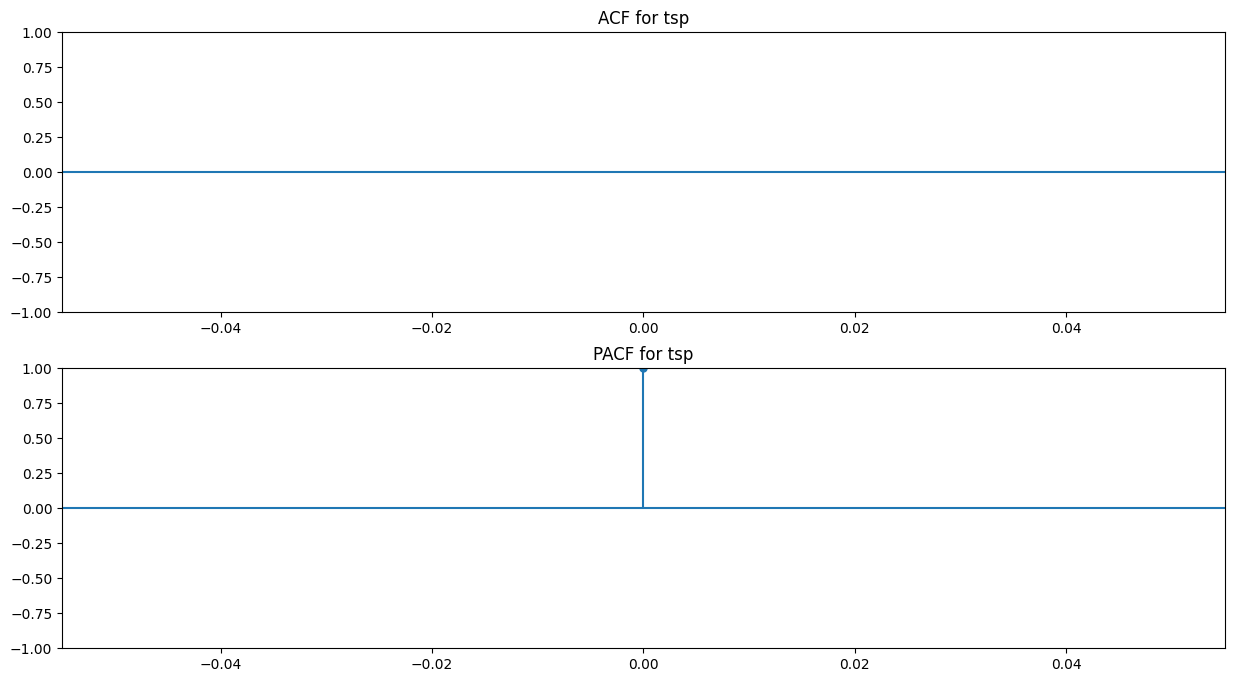

Analyze pm25...


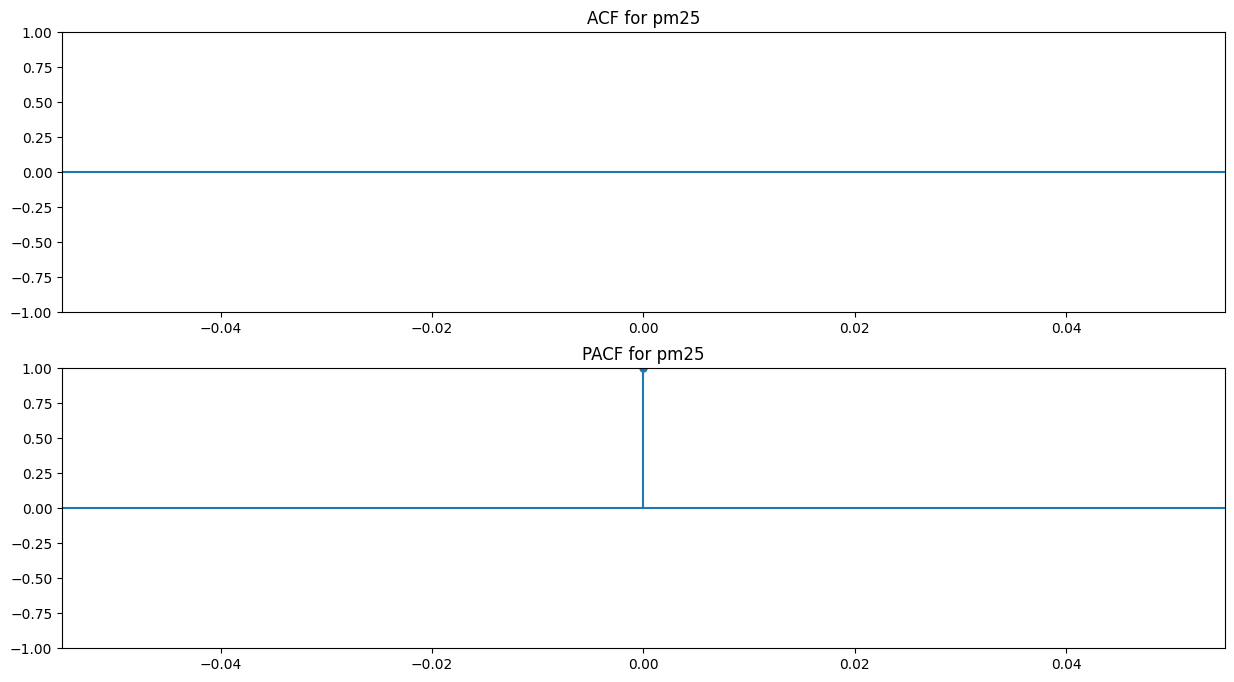

Analyze o3...


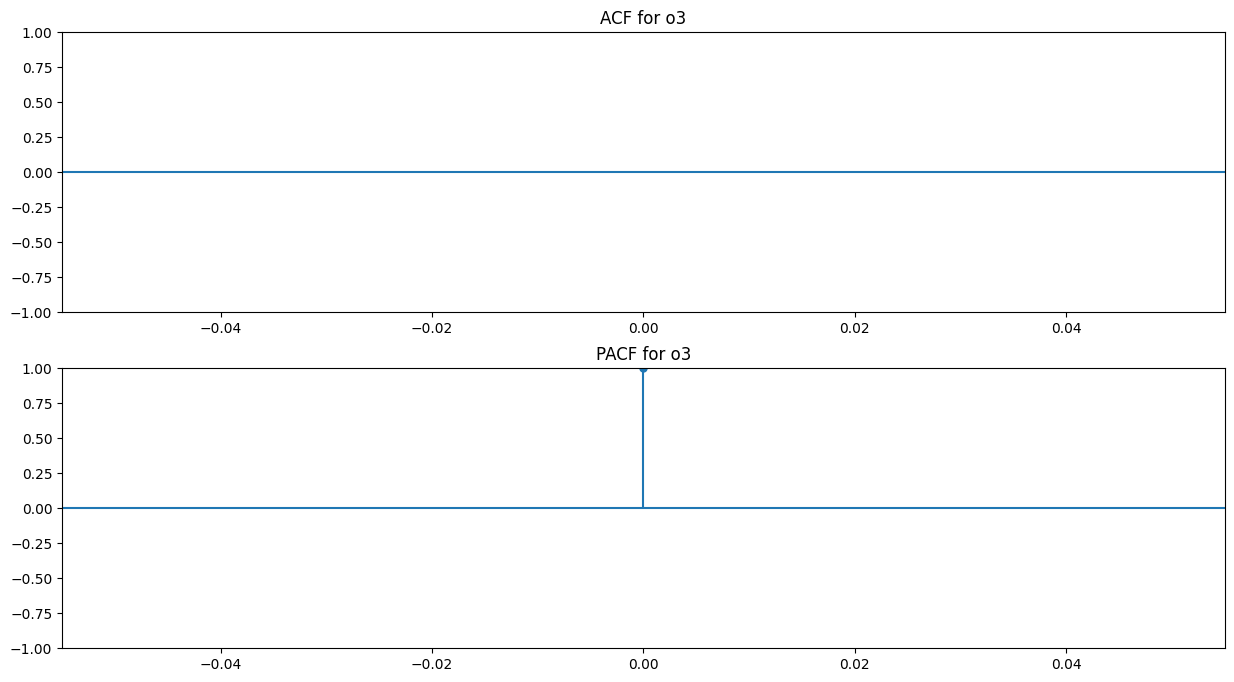

Analyze co...


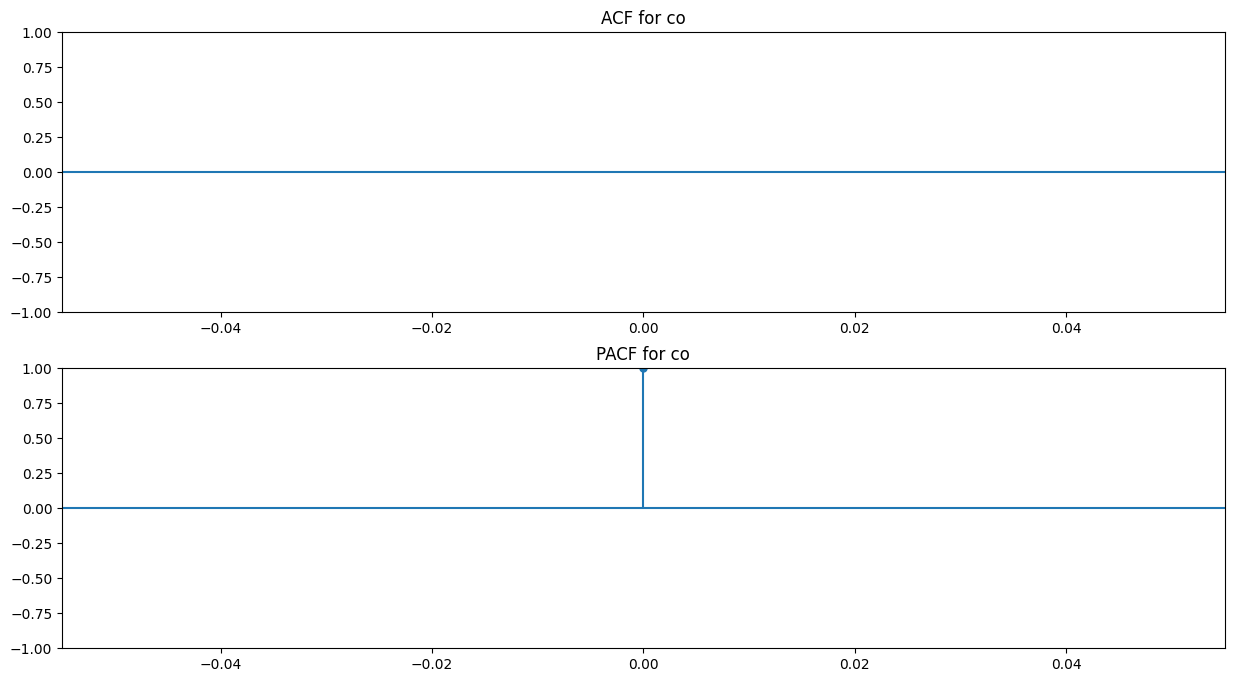

Analyze no2...


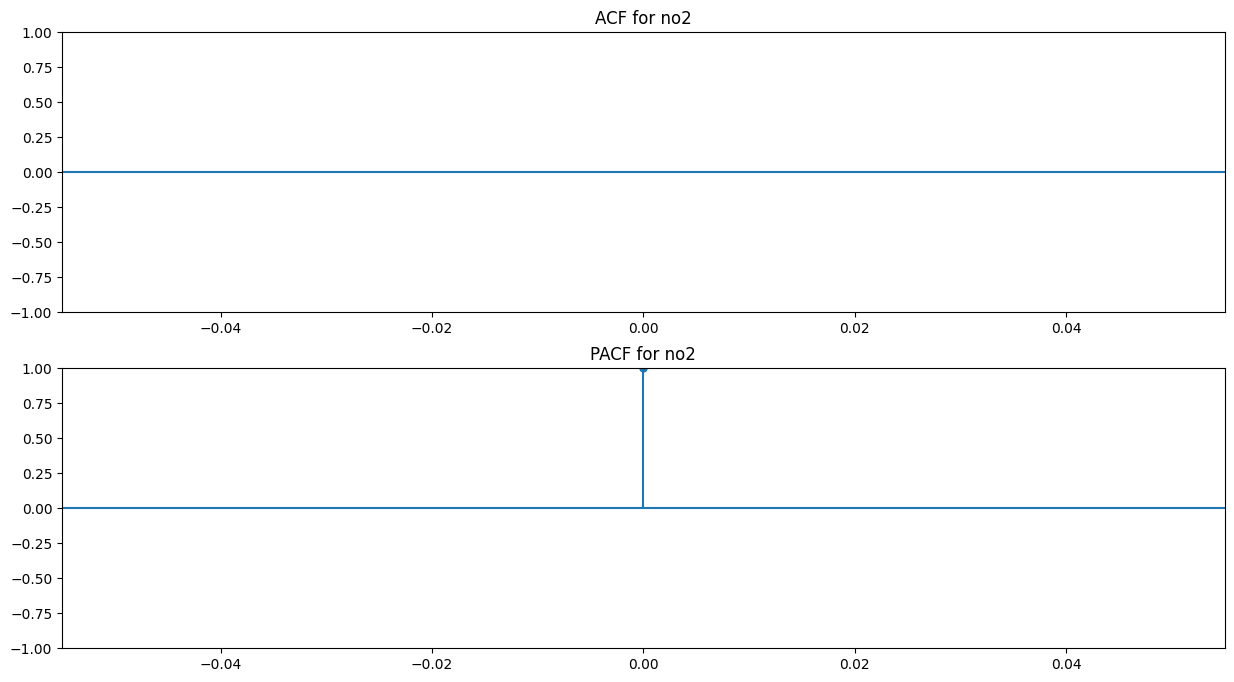

Analyze temperature...


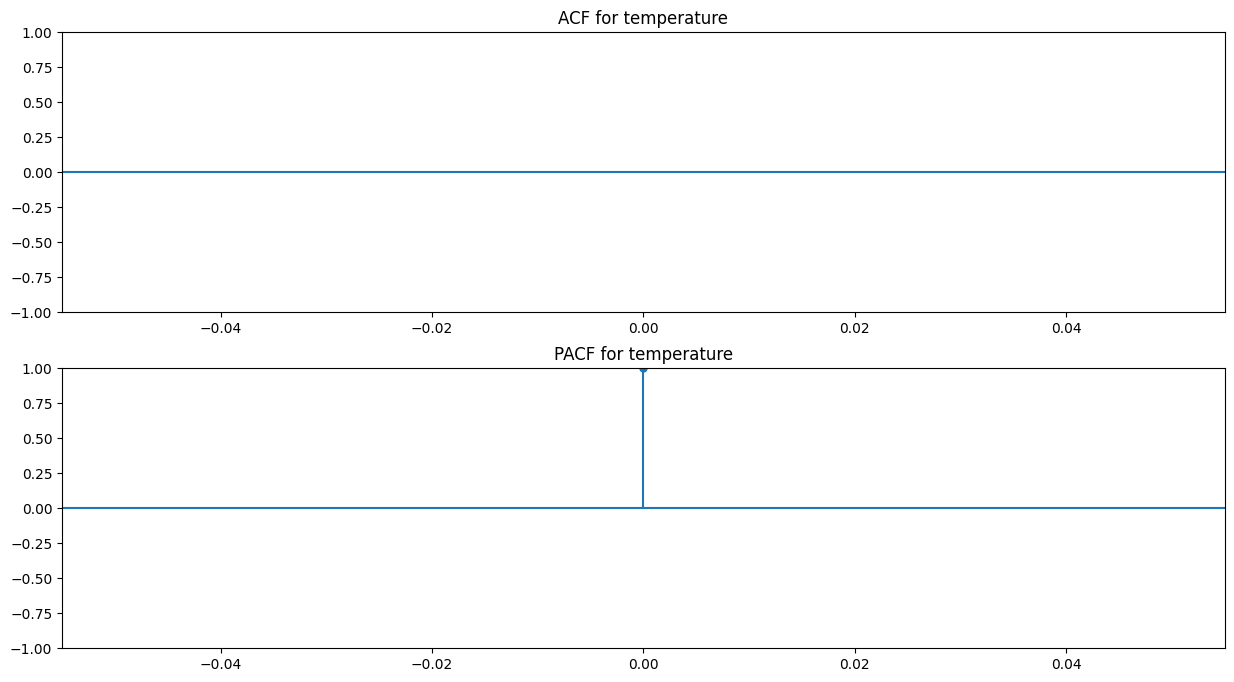

Analyze humid...


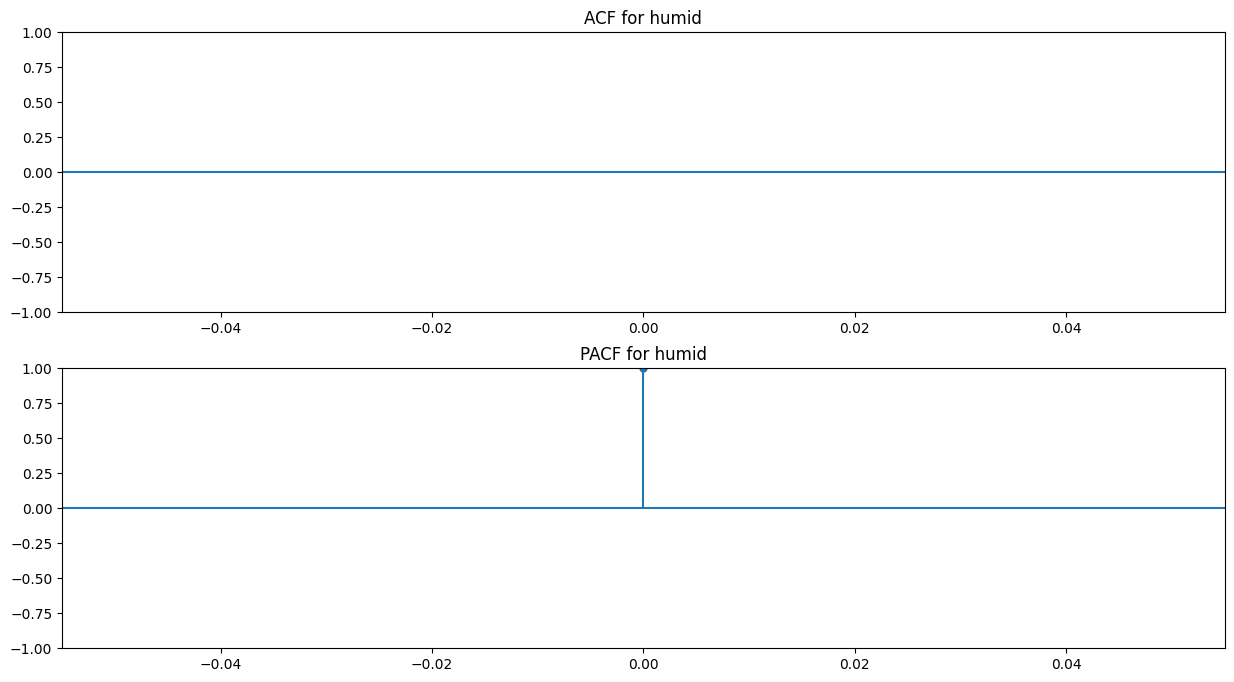

In [23]:
for feat in df_pm_raw.columns.drop("station"):
    print(f"Analyze {feat}...")
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
    plot_acf(df_pm_raw[feat], lags=168, title=f"ACF for {feat}", ax=ax[0])
    plot_pacf(df_pm_raw[feat], lags=168, title=f"PACF for {feat}", ax=ax[1], method='burg')
    plt.show()